# Student Name:*Weiyi Wang*




# Student Number:*0595445 *

## Step 1: Dataset loading

In [ ]:
from __future__ import absolute_import, division, print_function
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.preprocessing import OneHotEncode
!pip install sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

# load digits dataset with 5 classes. The dataset has 10 classes in total.
# You can change the amount of data as you like.
num_classes = 5
digits = load_digits(n_class=num_classes)
x = digits.data
y = digits.target
n_samples, n_features = x.shape

print("data shape: ",x.shape)
print("class shape: ",y.shape)

N_train = int(0.8 * x.shape[0])
x_train = x[:N_train,:]
y_train = y[:N_train]
x_test = x[N_train:,:]
y_test = y[N_train:]

# Add the bias term as a 1-column vector
x_train =np.hstack((x_train, np.ones((x_train.shape[0], 1))))# Your code
x_test =np.hstack((x_test, np.ones((x_test.shape[0], 1))))# Your codeß
#hstack is horizontally stack a column vector of ones to the right of your feature matrix,
#effectively adding a bias term to each data point.
#np.ones is used to create an array or matrix containing a specified number of ones

# Convert labels to one-hot vector.
# One hot vectors are vectors of size n_samples x n_classes
# On each row, all values are 0 except on the index of the corresponding class (which is 1)
# In a classification task of apples vs. pears vs. oranges. An apple would have a one-hot vector of (1 0 0), a pear would have a one-hot vector encoding of (0 1 0) and orange as (0 0 1)ß
# y_train_onehot = # Your code here
# Create the one-hot encoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the training labels
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))

# Transform the test labels
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

When using a sigmoid activation with one-hot labels for classification, the network outputs a probability for each possible class. This is a clear advantage over using the original form of labels. For example, when the network predicts a sample as number 1 and number 3 with 50% and 40% probabilities, respectively, we know that the sample could be a number 3, but it will be more likely to be a number 1. If we don't use one-hot encoding, the output would then likely be in the range of number 2, which would be completely wrong.

Check whether your one-hot conversion above is correct or not by the following

In [8]:
print(y_train[:5])
print(y_train_onehot[:5])

[0 1 2 3 4]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


## Step 2: Forward computation

Most deep learning frameworks provide a list of basic functions as building blocks, such as fully_connected, sigmoid, relu... so that you can stack them sequentially as layers to build your own neural networks. In this exercise, we will see implement the fully connected layer and the sigmoid activation function. In each function, we will return the result and the cache the input for backward computation later

In [9]:
# this function returns the probability of y=1
def sigmoid(x):
    cache = x
    result = 1.0/(1 + np.exp(-x))#Computes the output of the sigmoid function, a nonlinear function that maps inputs to values between 0 and 1.
    return cache, result

def fully_connected(x, theta): # performs a foward operation of x times \theta
    cache = (x, theta)
    result = np.dot(x, theta)# Your code
    return cache, result

After having our building blocks, we can start stacking layers.

In [50]:
def compute_forward(x, theta_matrices):
    '''
    x: feature vector
    theta_matrices: The list contains all theta. The first element is the theta (matrix) of the input layer and the first hidden
    layer, the second one is the theta of the fist hidden layer and the second hidden layer, and so on

    In this exercise, our network architecture will be:
    input -> fully_connected -> sigmoid -> fully_connected -> sigmoid -> output
    You don't need to use regularization in this exercise
    '''
    result = x
    cache = dict()
    for i, theta in enumerate(theta_matrices) :
        ## Your code here, should be a result of a fully_connected layer then a sigmoid activation.
        # Store the result of each computation in cache, for doing backprop later.
        # For this exercise, cache should have four items with keys: fc0, sigmoid0, fc1, sigmoid1
        fc = fully_connected(result, theta)[1]
        sigmoid_output = sigmoid(fc)[1]#只需要那个result所以加个[1]
        # Store the results and intermediate values in the cache
        cache[f'fc{i}'] = result, theta
        cache[f'sigmoid{i}'] = fc
        result = sigmoid_output
    return cache, result

def compute_cost(outputs, labels):
    '''mean square error'''
    result = np.sum((outputs - labels) ** 2) / (2 * labels.shape[0])## Your code
    return result

### Initialize theta and check the output shape

In [51]:
num_hidden = 100
theta0 = np.random.normal(loc=0., scale=0.5, size=(n_features+1, num_hidden+1)) # + 1 for bias term
theta1 = np.random.normal(loc=0., scale=0.5, size=(num_hidden+1, num_classes))
theta_matrices = [theta0, theta1]
cache, initial_outputs = compute_forward(x_train, theta_matrices)
assert initial_outputs.shape == y_train_onehot.shape, 'forward pass returns wrong shape'
print('forward pass returns correct shape')
initial_cost = compute_cost(initial_outputs, y_train_onehot)
print(initial_cost)#difference between target and output

forward pass returns correct shape
0.6734417669357058


## Step 3: Backpropagation

Similar to forward pass, calculating backward gradient using backpropagation is just like stacking several layers of gradient together. To do so, we first need to calculate the gradient of each of our building blocks.

In [45]:
def sigmoid_backward(cache, result):
    x = cache#是前向传播中保存的 Sigmoid 激活函数的输入值
    sigmoid_grad = sigmoid(x)[1] * (1 - sigmoid(x)[1])
    return sigmoid_grad * result #result is 反向传播的上游梯度。

def fc_backward(cache, result):
    x, theta = cache
    theta_grad = x.T.dot(result)
    x_grad = result.dot(theta.T)
    return x_grad, theta_grad

def cost_backward(outputs, labels):
    error = outputs - labels
    gradient = error / (2 * labels.shape[0])
    return gradient
    ## your code

In [46]:
def compute_backprop(x, theta_matrices, cache, outputs, labels):
    '''
    return gradients for theta_matrices
    '''
    theta_grad = {} # should include two key theta0 and theta1 for this exercise
    grad = cost_backward(outputs, labels)
    for i, theta in enumerate(theta_matrices[::-1]):
        layer = len(theta_matrices) - i - 1 # first iteration: layer 1, second iter: layer 0
        # Your code, first you need to propagate the gradient through the sigmoid activation,
        # then through the fully_connected layer
        sigmoid_grad = sigmoid_backward(cache[f'sigmoid{layer}'], grad)#caulate the sigmoid layer'gradient
        # 反向传播梯度通过全连接层
        x_grad, theta_grad[f'theta{layer}'] = fc_backward(cache[f'fc{layer}'], sigmoid_grad)
        # theta_grad[f'theta{layer}']= fc_backward(cache(f'fc{layer}', sigmoid_grad)[1]
        grad = x_grad
    return theta_grad

#### Check if compute_backprop returns the right shape

In [52]:
theta_grad = compute_backprop(x_train, theta_matrices, cache, initial_outputs, y_train_onehot)
dtheta0 = theta_grad['theta0']
print(dtheta0.shape)
print(theta0.shape)
# assert dtheta0.shape == theta0.shape,'bakprop returns wrong shape for theta 0'
#这是一个断言语句，用于验证 dtheta0 的形状是否符合预期。断言语句检查 dtheta0 的形状是否与 (n_features + 1, num_hidden + 1) 相同，
#其中 n_features 是输入特征的数量，num_hidden 是隐藏层神经元的数量。如果形状不匹配，将引发断言错误
##think of what size backprop should be
dtheta1 = theta_grad['theta1']
print(dtheta1.shape)
print(theta1.shape)
assert dtheta1.shape == theta1.shape, 'backprop returns wrong shape for theta 1'
##think of what size backprop should be

(65, 101)
(65, 101)
(101, 5)
(101, 5)


## Step 4: Training the network

Now that you have both forward and backward computation, use batch gradient descent to train the network.

training cost: 0.007377


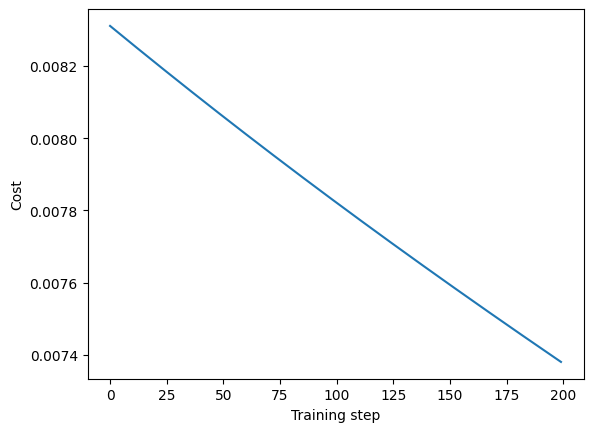

In [84]:
alpha = 0.2 # learning rate
N_iterations = 200 # You can play with this hyper-parameter to see how the network performs
J = np.zeros(N_iterations)#创建一个长度为 N_iterations 的零数组（或零向量）的操作，并将每次cost数值存在相应位置

for i in range(N_iterations):
    ## Your code
    # First, do a forward pass
    cache,result=compute_forward(x_train, theta_matrices)
    # Calculate the cost and store it in J[i]
    J[i]=compute_cost(result, y_train_onehot)
    # Calculate the gradients by doing a backward pass
    theta_grad=compute_backprop(x, theta_matrices, cache, result, y_train_onehot)
    # Update the weights by gradient descent rule
    for j, theta in enumerate(theta_matrices):
        theta -= alpha * theta_grad[f'theta{j}']


# calculate the loss on the whole training set
J_train = compute_cost(compute_forward(x_train, theta_matrices)[1], y_train_onehot)
print('training cost: %f' %J_train)

# plot cost function
plt.plot(J)
plt.xlabel('Training step')
plt.ylabel('Cost')
plt.show()

## Step 5: Evaluation

In [85]:
def compute_accuracy(y_ground_truth,y_pred): #of a classification task
    correct_predictions = np.sum(y_ground_truth == y_pred)
    total_samples = len(y_ground_truth)
    accuracy = correct_predictions / total_samples
    return accuracy
    ### YOUR CODE GOES  HERE ###

pred_one_max = compute_forward(x_test, theta_matrices)[1]

# Your prediction would be an one-hot vector, for each test sample, select the one with the highest probablity to assign the class
pred = np.argmax(pred_one_max, axis=1)## Your code
accuracy = compute_accuracy(y_test, pred)
print('accuracy: ', accuracy)
#according to tune the learning rate manually,i found LR=0.2 the accuracy is highest.

accuracy:  0.9171270718232044


## Challenge: Can you do better than the above model?
You can try to tune hyper-parameters, adding regularization, stacking more layers or implement different activation functions (tanh, ReLU)